# PDF 解析实践

## pdfplumber

https://github.com/jsvine/pdfplumber

pdfplumber 是一个用于解析 PDF 文档的 Python 库。它提供了一种简单而高效的方式来提取和操作 PDF 文档中的文本、图像和表格。

1. 使用 extract_text 函数提取全部文本

  > x_tolerance 是 x 方向上的容差，两个字符之间的距离小于 x_tolerance 时认为它们属于一个单词。

In [3]:
import pdfplumber

with pdfplumber.open("./assets/example2.pdf") as pdf:
    first_page = pdf.pages[0]  # 获取第一页
    text = first_page.extract_text(x_tolerance=2, y_tolerance=3)  # 提取全部文本
    print(text)

Example PDF
This is a line of text
这是一行文本
 无序列表项 1
 无序列表项 2
 无序列表项 3
1. 有序列表项 1
2. 有序列表项 2
3. 有序列表项 3
TH0 TH1 TH2
td01 td11 td21
td02 td12 td22
The End.


使用 `extract_words` 函数提取单词，同时还可以获取每个单词的位置信息。

In [4]:
import pdfplumber

with pdfplumber.open("./assets/example2.pdf") as pdf:
    first_page = pdf.pages[0]  # 获取第一页
    words = first_page.extract_words(x_tolerance=2, y_tolerance=3)  # 提取全部单词
    print(words)
    for word in words:
        print(word["text"])

[{'text': 'Example', 'x0': 239.88, 'x1': 315.34704999999997, 'top': 79.98840000000007, 'doctop': 79.98840000000007, 'bottom': 101.9384, 'upright': True, 'height': 21.949999999999932, 'width': 75.46704999999997, 'direction': 'ltr'}, {'text': 'PDF', 'x0': 320.4, 'x1': 355.4344499999999, 'top': 79.98840000000007, 'doctop': 79.98840000000007, 'bottom': 101.9384, 'upright': True, 'height': 21.949999999999932, 'width': 35.034449999999936, 'direction': 'ltr'}, {'text': 'This', 'x0': 90.0, 'x1': 107.04535, 'top': 107.46039999999994, 'doctop': 107.46039999999994, 'bottom': 117.91039999999998, 'upright': True, 'height': 10.450000000000045, 'width': 17.04535, 'direction': 'ltr'}, {'text': 'is', 'x0': 109.44, 'x1': 115.92595, 'top': 107.46039999999994, 'doctop': 107.46039999999994, 'bottom': 117.91039999999998, 'upright': True, 'height': 10.450000000000045, 'width': 6.4859500000000025, 'direction': 'ltr'}, {'text': 'a', 'x0': 118.44, 'x1': 123.44555, 'top': 107.46039999999994, 'doctop': 107.460399

提取表格

In [5]:
with pdfplumber.open("./assets/example2.pdf") as pdf:
  page = pdf.pages[0]
  # 基础表格提取
  table = page.extract_table()
  for row in table:
    print(row)

['TH0', 'TH1', 'TH2']
['td01', 'td11', 'td21']
['td02', 'td12', 'td22']


`extract_text` 和 `extract_table` 都能提取到表格中的文字，造成重复提取，需要在提取文本时排除已经被识别为表格的部分，以避免重复。

In [6]:
import pdfplumber
import pandas as pd

def extract_elements(pdf_path):
    elements = []
    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages):
            # 提取表格区域坐标
            tables = page.find_tables()
            table_bboxes = [table.bbox for table in tables]
            
            # 提取文本块（过滤表格区域）
            text_blocks = []
            words = page.extract_words(x_tolerance=2, y_tolerance=3)
            current_line = []
            for word in words:
                # 判断是否在表格区域内[1,7](@ref)
                if any(word["x0"] >= bbox[0] and word["x1"] <= bbox[2] and 
                       word["top"] >= bbox[1] and word["bottom"] <= bbox[3] 
                       for bbox in table_bboxes):
                    continue
                
                # 合并成行
                if not current_line:
                    current_line.append(word)
                else:
                    last_word = current_line[-1]
                    if abs(word["top"] - last_word["top"]) < 2:
                        current_line.append(word)
                    else:
                        text_blocks.append({
                            "text": " ".join([w["text"] for w in current_line]),
                            "top": current_line[0]["top"]
                        })
                        current_line = [word]
            if current_line:
                text_blocks.append({
                    "text": " ".join([w["text"] for w in current_line]),
                    "top": current_line[0]["top"]
                })
            
            # 添加元素
            elements.extend([
                {"type": "text", "content": tb["text"], "page": page_num, "y": tb["top"]} 
                for tb in text_blocks
            ])
            
            # 添加表格
            for table in tables:
                df = pd.DataFrame(table.extract()[1:], columns=table.extract()[0])
                elements.append({
                    "type": "table", 
                    "content": df.to_markdown(index=False),
                    "page": page_num,
                    "y": table.bbox[1]
                })

            # 添加图片
            for image in page.images:
                elements.append({
                    "type": "image",
                    # 上传图片到图床，返回图片链接 f'[Image]({url})'
                    "content": f'[Image](url)',
                    "page": page_num,
                    "y": image["top"]
                })
                
            
    return elements

def sort_elements(elements):
    # 按页码->垂直位置->水平位置排序[3,7](@ref)
    sorted_elements = sorted(elements, key=lambda x: (x["page"], x["y"], x.get("x0",0)))
    
    # 处理分栏布局（以两栏为例）
    final_order = []
    current_page = -1
    column_threshold = None
    
    for elem in sorted_elements:
        if elem["page"] != current_page:
            current_page = elem["page"]
            # 计算分栏阈值（假设页面宽度为A4：595pt）
            column_threshold = 595 / 2 - 20  # 留20pt边距
            
        # 判断是否属于右栏
        if elem.get("x0", 0) > column_threshold:
            # 延迟到左栏内容之后插入
            final_order.append(("right", elem))
        else:
            final_order.append(("left", elem))
    
    # 重组分栏内容
    output = []
    left_buffer, right_buffer = [], []
    for pos, elem in final_order:
        if pos == "left":
            if right_buffer:
                output.extend(right_buffer)
                right_buffer = []
            output.append(elem)
        else:
            right_buffer.append(elem)
    output.extend(right_buffer)
    return output

In [7]:
example2_elements = sort_elements(extract_elements("./assets/example2.pdf"))
for element in example2_elements:
    print(element.get('text') or element.get('content'))

Example PDF
This is a line of text
这是一行文本
 无序列表项 1
 无序列表项 2
 无序列表项 3
1. 有序列表项 1
2. 有序列表项 2
3. 有序列表项 3
| TH0   | TH1   | TH2   |
|:------|:------|:------|
| td01  | td11  | td21  |
| td02  | td12  | td22  |
[Image](url)
The End.


真实文档测试

In [8]:
import os

result = sort_elements(extract_elements('./assets/example3.pdf'))
content = '\n\n'.join([element.get('text') or element.get('content') for element in result])

output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(f'{output_dir}/result.md', 'w', encoding='utf-8') as f:
    f.write(content)

## tabula-py

https://github.com/chezou/tabula-py

基于 tabula-java 构建的一种用于从 PDF 文件中提取表格的工具。使用前要确保 java 环境已经安装。

In [13]:
import os
import tabula

print(os.getenv('JAVA_HOME')) # tabula 依赖此环境变量

dfs = tabula.read_pdf("./assets/example3.pdf", pages='all', multiple_tables=True)
content = '\n\n'.join([df.to_markdown(index=False) for df in dfs])

output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(f'{output_dir}/result_tabula.md', 'w', encoding='utf-8') as f:
    f.write(content)

C:\Program Files\Java\jdk-24


## 视觉大模型方案

### olmocr
https://olmocr.allenai.org/

硬件需求：
- Recent NVIDIA GPU (tested on RTX 4090, L40S, A100, H100) with at least 20 GB of GPU RAM
- 30GB of free disk space

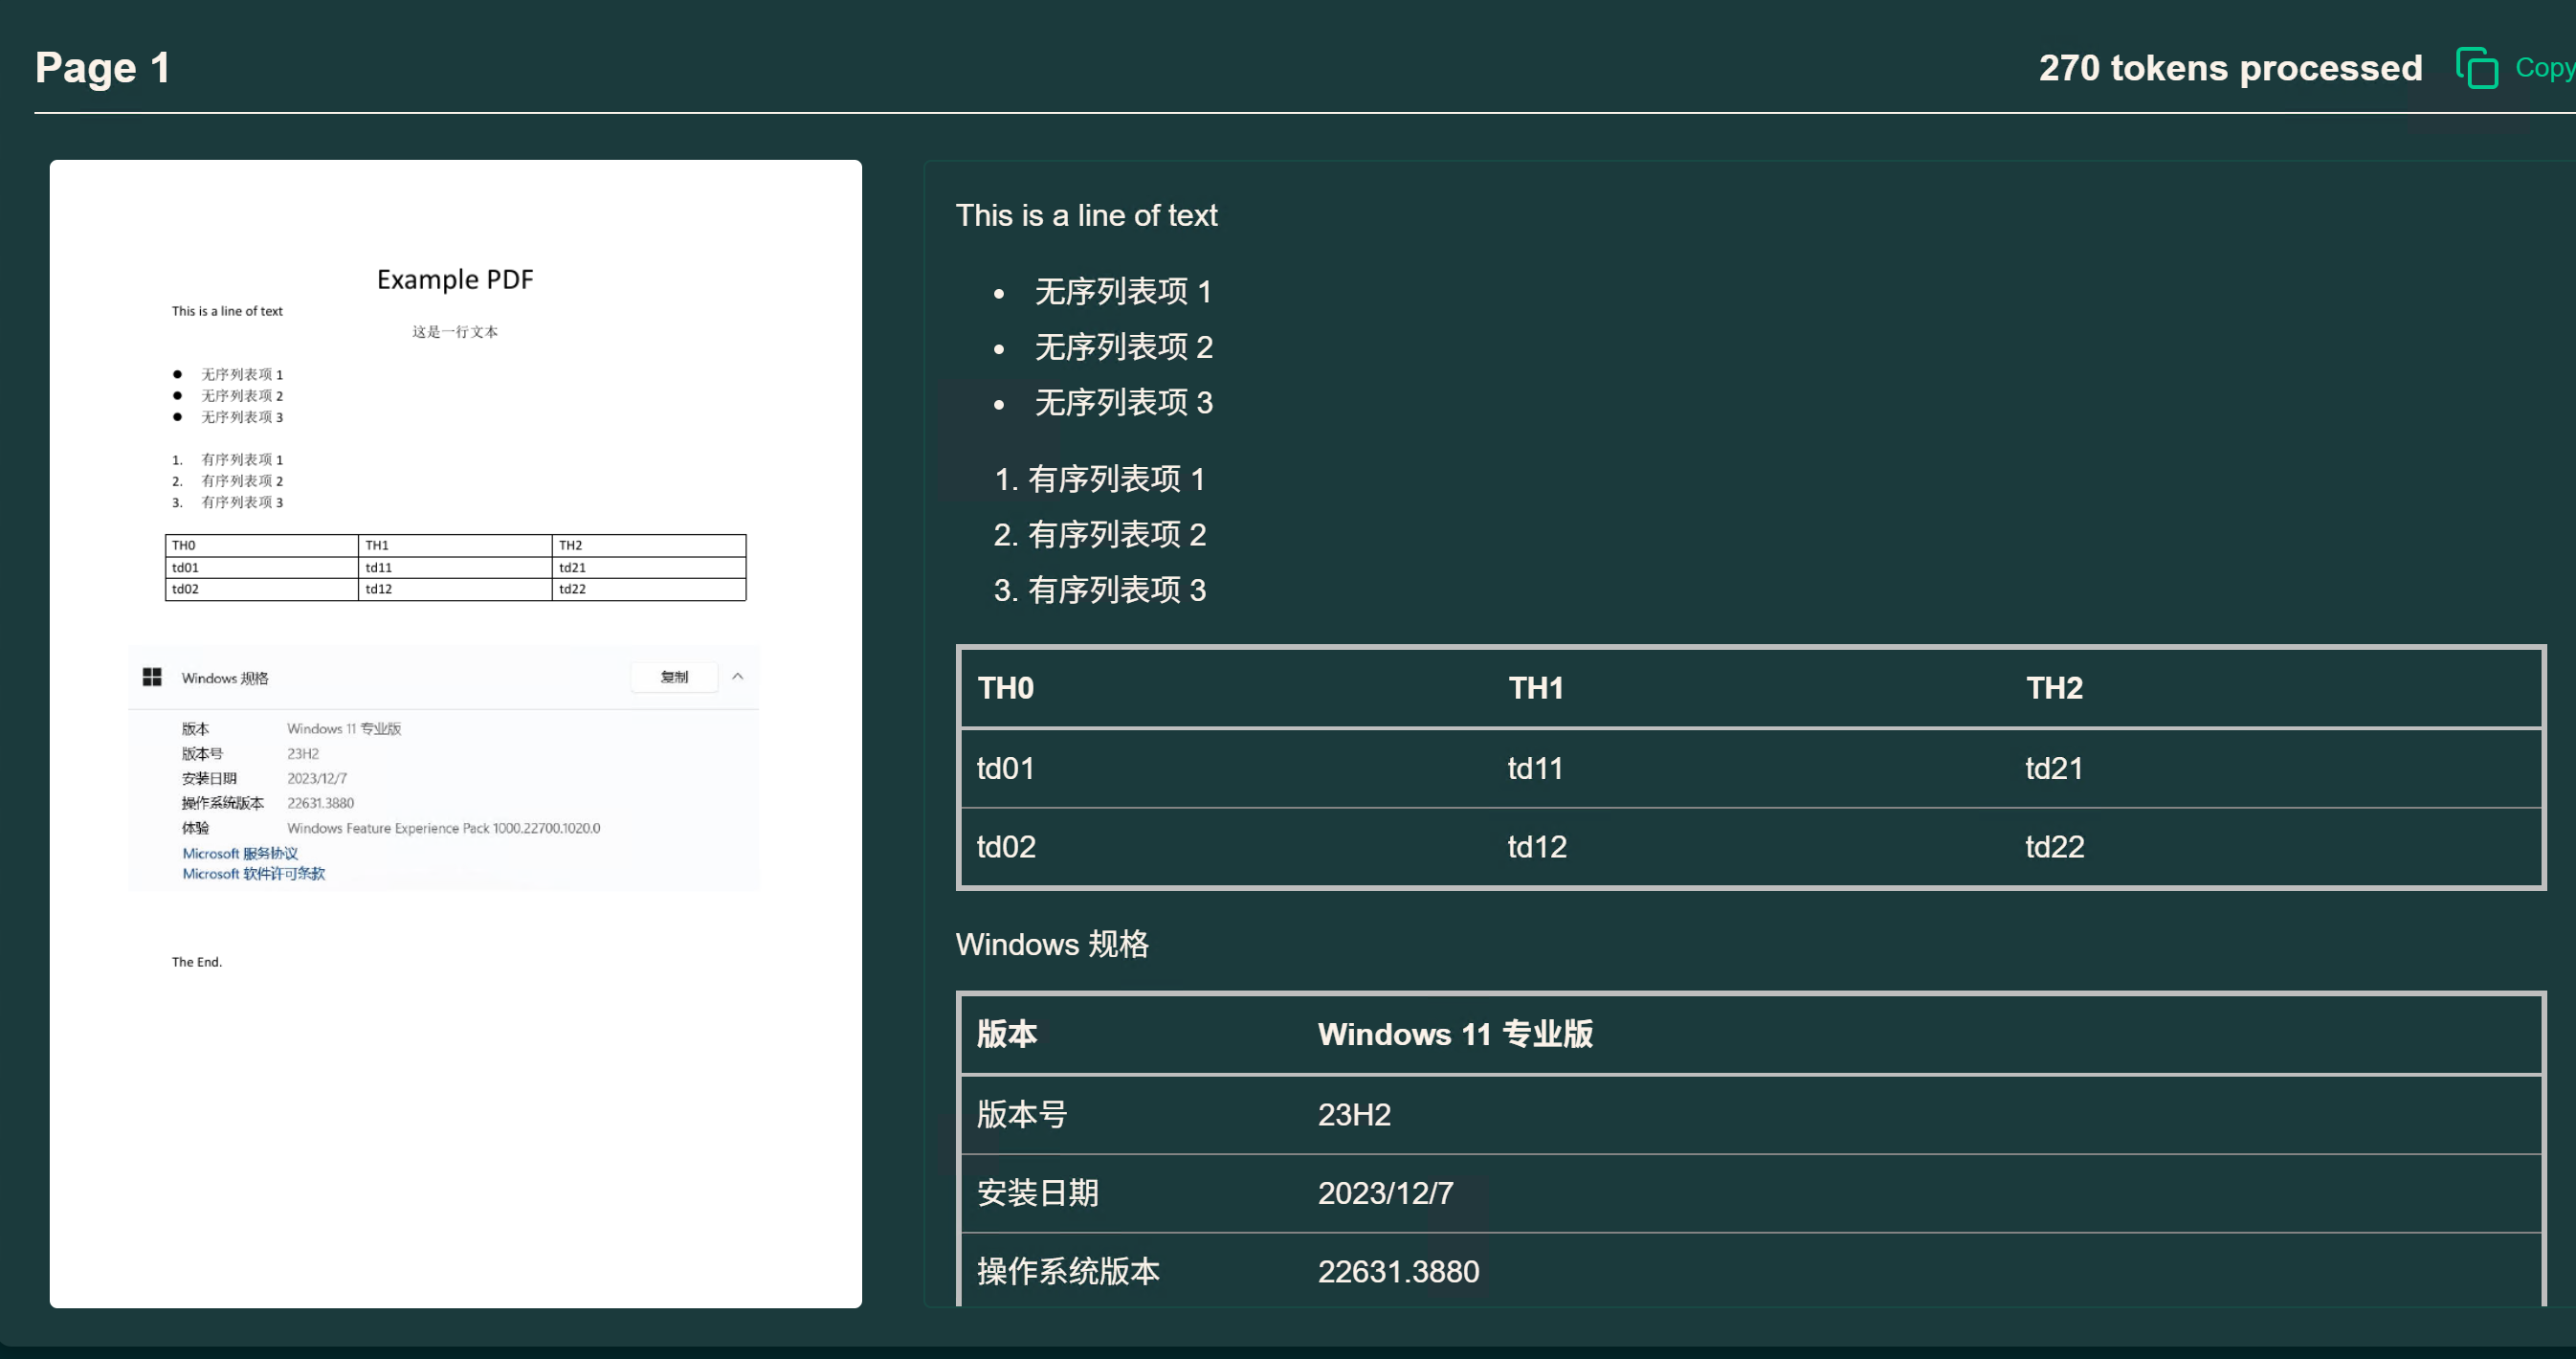